In [123]:
import datetime
import re
from typing import List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from sklearn.utils import resample

In [124]:
# general purpose: merge_data, process_data, pit_stop_group
def merge_data(_df_list: List[pd.DataFrame]) -> pd.DataFrame:
    """
    merges the dataframes according to their primary/foreign keys
    :param _df_list: list of dataframes to be merged
    :return: the merged dataframe
    """
    # set up internal parameters
    suffixes = ['_1', '_2']
    r = re.compile('\w*Id')

    # set up variables based on input
    num = len(_df_list)  # length of the list
    to_select = list(range(1, num))  # list of indexes of dataframe to be merged
    remaining = set(range(1, num))  # set of remaining indexes of dataframes yet to be merged

    # get all the '<something>id' columns for each dataframe
    id_list = [set(filter(r.match, table)) for table in _df_list]
    # set up the merged dataframe, 'mg_df'
    mg_df = _df_list[0]
    mg_id = id_list[0]  # set the id set of the merged dataframe as the first dataframe's id set

    # start merging dataframes
    while True:
        merge_flag = 0  # flag indicating if a while-true run has merged any new dataframe
        for index in to_select:
            intersect = mg_id.intersection(id_list[index])
            all_col_intersect = set(mg_df.columns).intersection(set(_df_list[index].columns))
            # iterate through the remaining dataframe
            # and merge those with common id(s)
            if (index in remaining) and intersect:
                if all_col_intersect == intersect:
                    mg_df = pd.merge(mg_df, _df_list[index], on=list(intersect), how='left')
                else:
                    # if there are other common columns than the ids, set suffixes
                    mg_df = pd.merge(mg_df, _df_list[index], on=list(intersect), how='left', suffixes=suffixes)
                # add the new ids into the total id set of the merged dataframe
                mg_id = mg_id.union(set(id_list[index]))
                remaining.remove(index)  # remove the index of the added dataframe
                merge_flag = 1
        if not remaining:
            break  # break if there is no more dataframe to be added
        if not merge_flag:  # if no new dataframe was merged in this while-true run
            print('Error: no common "id" columns found')
            break  # breaks
    return mg_df

In [125]:
def process_data(mg_df: pd.DataFrame, normal_status=True) -> pd.DataFrame:
    """
    process the data for analysis:
    1. filter normal status
    2. add total laps for each record
    3. add total pit stops for each record
    4. calculate the proportion of lap when the driver pit for each pit record
    5. calculate how far the lap proportion deviates from the ideal even distribution for each pit record
    :param mg_df: the merged dataframe
    :param normal_status: if filter the dataframe with records that are finished or +? laps away from the finished
    :return: the processed dataframe
    """
    # 1. filtering normal status
    if normal_status:
        _status_select = [1, 11, 12, 13, 14, 15, 16, 17, 18, 19]
        mg_df.drop(mg_df[~mg_df['statusId'].isin(_status_select)].index, inplace=True)
    # 2&3. add total laps & total pit stops for each record
    _total_laps = mg_df[(mg_df['positionOrder'] == 1) & (mg_df['stop'] == 1)].reset_index(drop=True)[['raceId', 'laps']]
    _total_laps.columns = [str(_total_laps.columns[0]), 'total_laps']
    _total_stops = mg_df.groupby(by=['raceId', 'driverId'], as_index=False)['stop'].max()
    _total_stops.columns = list(_total_stops.columns[:2]) + ['total_stops']
    # 4. calculate the proportion of lap when the driver pit for each pit record
    mg_df = pd.merge(mg_df, _total_laps, on='raceId')
    mg_df = pd.merge(mg_df, _total_stops, on=['raceId', 'driverId'])
    # 5. calculate how far the lap proportion deviates from the ideal even distribution for each pit record
    mg_df['lap_prop'] = mg_df.apply(lambda x: x['lap'] / x['total_laps'], axis=1)
    mg_df['abs_deviation'] = mg_df.apply(lambda x: abs(x['stop'] / (x['total_stops'] + 1) - x['lap_prop']), axis=1)
    # 6. deviation mean, grouped by each driver in each race
    avg_deviation = pd.DataFrame(mg_df.groupby(['raceId', 'driverId'])['abs_deviation'].mean())
    avg_deviation = avg_deviation.add_suffix('_mean').reset_index()
    mg_df = pd.merge(mg_df, avg_deviation, on=['raceId', 'driverId'])

    return mg_df

In [126]:
def pit_stop_group(df: pd.DataFrame) -> dict:
    """
    group the records by the total number of pit stops of each racing record
    :param df: the merged and processed dataframe
    :return: a dictionary with total pit numbers as keys and dataframe of records as values
    """
    max_num = df['total_stops'].max()
    _df_dict = {}
    for i in range(1, max_num+1):
        _df_dict[i] = df[df['total_stops']==i][['stop','positionOrder','lap_prop']]
    return _df_dict


In [127]:
def pit_stop_group_by_driver(df: pd.DataFrame) -> pd.DataFrame:
    pitstop_df = df[["raceId", "driverId",'positionOrder', "total_stops"]]
    pitstop_groupby = pitstop_df.groupby(["raceId", "driverId",'positionOrder'], as_index=False)["total_stops"].count()
    pitstop_groupby.sort_values(by=["raceId", 'driverId'], inplace=True)
    print(pitstop_groupby)
    return (pitstop_groupby)

In [128]:
# Load data
pit = pd.read_csv('data/pit_stops.csv')
results = pd.read_csv('data/results.csv')
status = pd.read_csv('data/status.csv')

In [129]:
# Process the data files
merge_df = merge_data([pit, results, status])
merge_df = process_data(merge_df)
df_dict = pit_stop_group(merge_df)
df_plot = pit_stop_group_by_driver(merge_df)

      raceId  driverId  positionOrder  total_stops
0        841         1              2            2
1        841         2             12            2
2        841         4              4            3
3        841        10             15            1
4        841        13              7            3
...      ...       ...            ...          ...
3793    1076       848             10            1
3794    1076       849             16            2
3795    1076       852             15            1
3796    1076       854             13            1
3797    1076       855             11            1

[3798 rows x 4 columns]


In [130]:
# def pitstop_boxplot(group_dict: dict):
#     df_final = pd.DataFrame(columns=['stop','positionOrder'])
#     if len(group_dict) % 2 ==0:
#         for key in group_dict:
#             if key % 2 == 1:
#                 continue
#             else:
#                 df_union = pd.concat([group_dict[key][['stop','positionOrder']],group_dict[key-1][['stop','positionOrder']]])
#                 df_final = pd.concat([df_final,df_union])
#
#     # else:
#         df_final['stop'] = df_final['stop'].astype(str).astype(int)
#         df_final['positionOrder'] = df_final['positionOrder'].astype(str).astype(int)
#         return df_final
#         boxplot = df_final.boxplot(by="stop")
#         # return boxplot
#         boxplot.plot()
#         plt.show()

In [131]:
def pitstop_boxplot(df: pd.DataFrame)-> plt:
    boxplot_base = df[["total_stops", "positionOrder"]]
    boxplot = boxplot_base.boxplot(by="total_stops")
    boxplot.plot()
    plt.show()


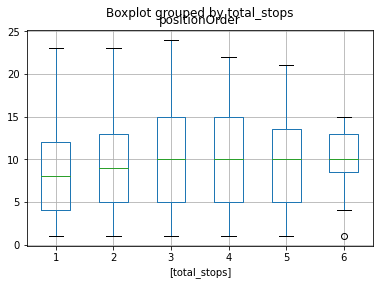

In [132]:
pitstop_boxplot(df_plot)